<a id='0'></a>
## Описание проекта

Построить модель для предсказания количества заказов такси на следующий час.   
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Количество заказов находится в столбце '*num_orders*'.

### План работы

[1. Подготовка данных](#1)      
[2. Анализ](#2)        
[3. Обучение моделей](#3)     
[4. Выводы](#4)    

# Подготовка

### Импорт библиотек

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

#graphics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (16,5)})

#TimeSeries
from statsmodels.tsa.seasonal import seasonal_decompose

#ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

### Функции

In [3]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Add calendar features, lag features with max_lag and rolling mean with rolling_mean_size to data.
    '''
#    data['month'] = data.index.month
    data['weekday'] = data.index.dayofweek
#    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag+1):
        data[f'lag_{i}'] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data = data.dropna()
    
    return data


def predict_results(prediction):
    """
    print RMSE score on test and graphic of target and predicted value
    """
    
    print("RMSE тестовой выборки: ", mean_squared_error(test_y, prediction)**0.5)
    
    test_prediction = pd.DataFrame(test_y, index=test.index)
    test_prediction['predict'] = prediction
    test_prediction.plot()

<a id='1'></a>
### Загрузка файла

In [4]:
file_name = 'taxi.csv'
df = pd.read_csv(file_name, parse_dates=[0], index_col=[0])

df.info()
print('Временной ряд непрерывен:', df.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Временной ряд непрерывен: True


In [5]:
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


### Ресеплинг

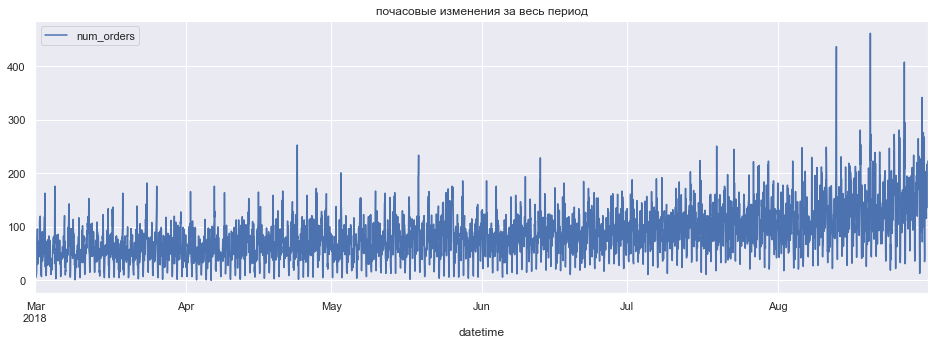

In [6]:
df = df.resample('1H').sum()
df.plot()
plt.title('почасовые изменения за весь период')
plt.show()

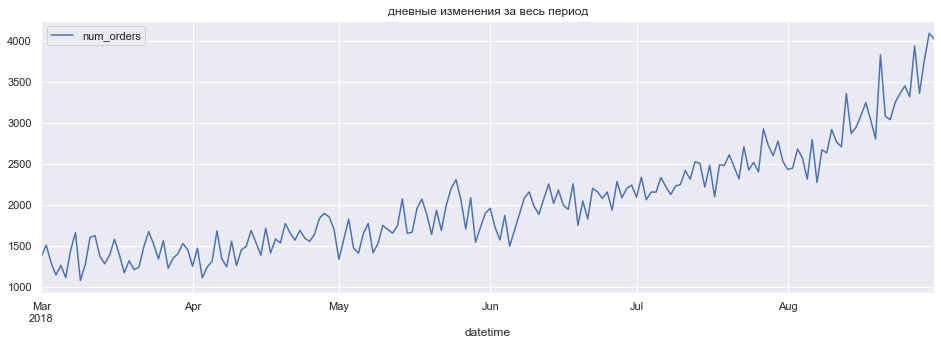

In [7]:
df_per_day = df.resample('1D').sum()
df_per_day.plot()
plt.title('дневные изменения за весь период')
plt.show()

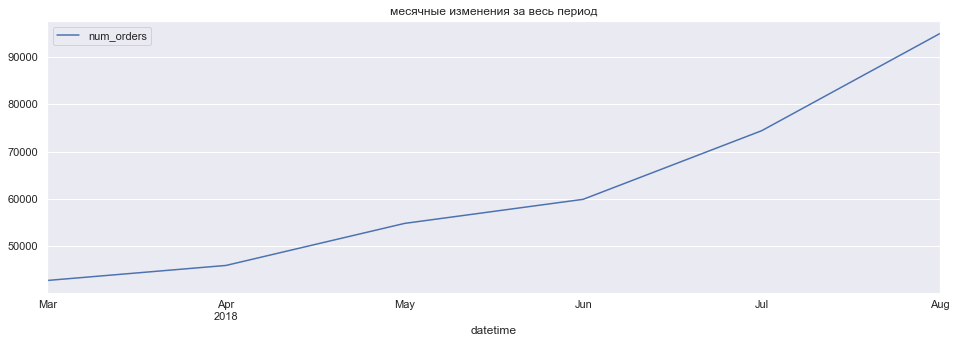

In [8]:
df.resample('1M').sum().plot()
plt.title('месячные изменения за весь период')
plt.show()

Из графиков выше видно, что есть восходящий тренд.

<a id='2'></a>
# Анализ
[к началу](#0)

Сохраним срез за последнюю неделю в переменной `df_one_week`

In [9]:
df_one_week = df['2018-08-25':'2018-08-31']

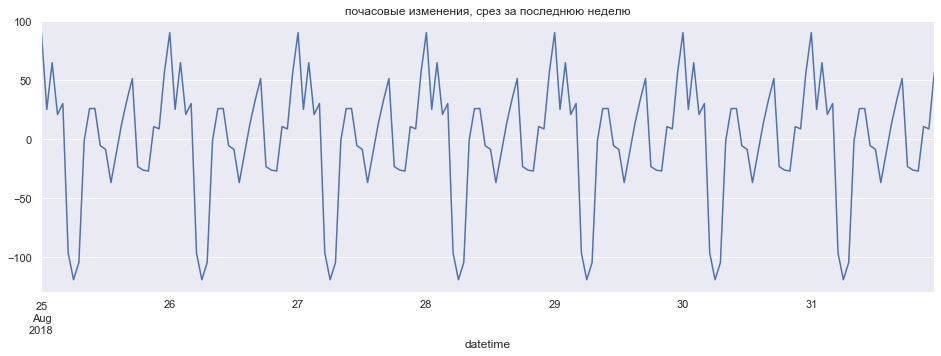

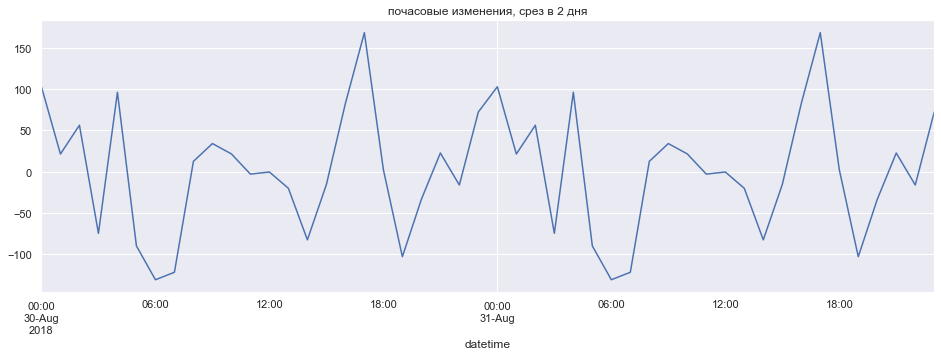

In [10]:
seasonal_decompose(df_one_week).seasonal.plot()
plt.title('почасовые изменения, срез за последнюю неделю')
plt.show()

seasonal_decompose(df['2018-08-30':'2018-08-31']).seasonal.plot()
plt.title('почасовые изменения, срез в 2 дня')
plt.show()

есть почасовая сезонность, минимум заказов приходится на 6-7 утра, макс на 17-18. Посмотрим есть ли связь с днем недели.

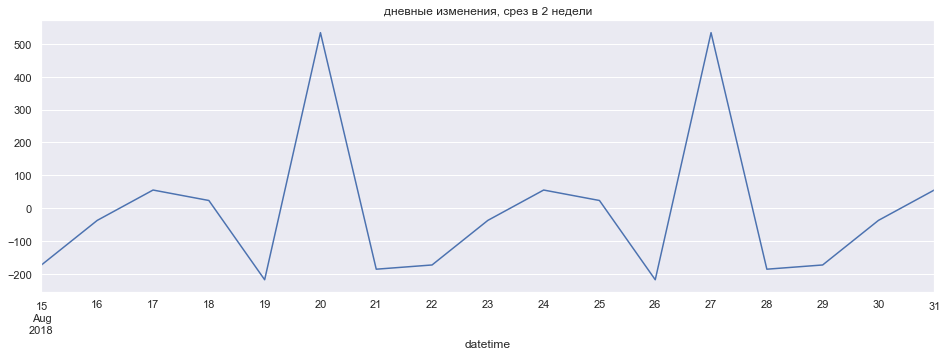

In [11]:
seasonal_decompose(df_per_day['2018-08-15':'2018-08-31']).seasonal.plot()
plt.title('дневные изменения, срез в 2 недели')
plt.show()

In [12]:
df_per_day['weekday'] = df_per_day.index.dayofweek
df_per_day.tail(1)

,num_orders,weekday
datetime,,
2018-08-31,4018,4


Есть недельная сезонность. Пик заказов приходится на воскресенье, а минимум на субботу и понедельник

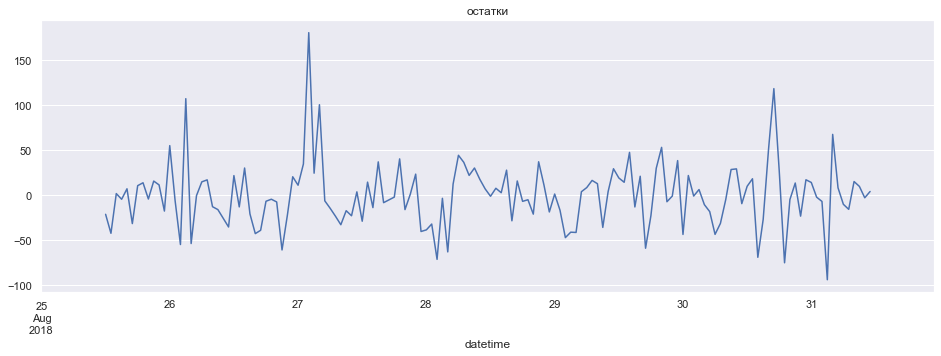

In [13]:
seasonal_decompose(df_one_week).resid.plot()
plt.title('остатки')
plt.show()

### Вывод:
- Кажется, что прослеживается восходящий тренд: этот подъем за счет роста компании или есть еще влияние месячной сезонности? Так как данных меньше года, то нельзя сделать корректных выводов по тренду
- почасовая сезонность: меньше всего заказов такси приходится на 6 утра, больше всего - на 17-18 часов
- недельная сезонность: пик заказов в восресенье, минимум - суббота и понедельник

так как задача построить прогноз на очень маленький горизонт - час - то этих двух сезонностей может и хватить

<a id='3'></a>
# Обучение
[к началу](#0)

Обучим и сравним следующие модели: LinearRegression, RandomForestRegressor, LGBMRegressor

In [14]:
results_dict = {}

### Подготовка данных к обучению

In [15]:
data = make_features(df_one_week, 2, 3)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train_x = train.drop('num_orders', axis=1)
train_y = train['num_orders']
test_x = test.drop('num_orders', axis=1)
test_y = test['num_orders']

In [16]:
data.head(2)

,num_orders,weekday,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-08-25 03:00:00,187,5,3,160.0,246.0,226.333333
2018-08-25 04:00:00,196,5,4,187.0,160.0,197.666667


### Проверка на адекватность
1. Сделаем прогноз предыдущими значениями

In [17]:
pred_previous = pd.DataFrame(test_y, index=test.index).shift()
pred_previous.iloc[0] = train.iloc[-1]

results_dict['pred_previous'] = ['NaN']
results_dict['pred_previous'].append(mean_squared_error(test_y, pred_previous)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous
RMSE_train,NaN
RMSE_test,48.4392


2. Проверим константой

In [18]:
constant = pd.DataFrame(np.ones(len(test_y))*train_y.mean(), index=test.index)

results_dict['constant'] = ['NaN']
results_dict['constant'].append(mean_squared_error(test_y, constant)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous,constant
RMSE_train,NaN,NaN
RMSE_test,48.4392,46.2286


### Линейная регрессия

In [19]:
lin_model = LinearRegression()
lin_model.fit(train_x, train_y)
lin_predict_train = lin_model.predict(train_x)
lin_predict_test = lin_model.predict(test_x)

results_dict['LinearRegression'] = [mean_squared_error(train_y, lin_predict_train)**0.5]
results_dict['LinearRegression'].append(mean_squared_error(test_y, lin_predict_test)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous,constant,LinearRegression
RMSE_train,NaN,NaN,55.413404
RMSE_test,48.4392,46.2286,36.404503


Проврить хвост, осталась ли там информация о сезонности?

### Случайный лес

In [20]:
params = {
    'n_estimators': range(27, 34),
    'max_depth' : range(2, 10)
}

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(RandomForestRegressor(random_state = 333), 
                    param_grid=params,
                    scoring='neg_mean_squared_error',
                    cv=tscv)
grid.fit(train_x, train_y)
grid.best_params_

{'max_depth': 7, 'n_estimators': 31}

In [21]:
RF_model = RandomForestRegressor(random_state = 333, max_depth=8, n_estimators=31)
RF_model.fit(train_x, train_y)
RF_predict_train = RF_model.predict(train_x)
RF_predict_test = RF_model.predict(test_x)

results_dict['RandomForestRegressor'] = [mean_squared_error(train_y, RF_predict_train)**0.5]
results_dict['RandomForestRegressor'].append(mean_squared_error(test_y, RF_predict_test)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous,constant,LinearRegression,RandomForestRegressor
RMSE_train,NaN,NaN,55.413404,22.260495
RMSE_test,48.4392,46.2286,36.404503,34.078873


### LGBMRegressor

In [22]:
params = {
    'learning_rate': [0.1, 0.6],
    'max_depth': [3, 9],
    'num_leaves': [30, 90, 10],
    'boost': ['goss', 'gbdt', 'rf']
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(LGBMRegressor(random_state=333),
                    param_grid=params,
                    cv=tscv,
                    scoring='neg_mean_squared_error',
                    verbose=1)

grid.fit(train_x, train_y)
grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    2.9s finished


{'boost': 'gbdt', 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 30}

In [23]:
LGBM_model = LGBMRegressor(boost='gbdt', learning_rate=0.1, max_depth=3, num_leaves=30)
LGBM_model.fit(train_x, train_y)
LGBM_predict_train = LGBM_model.predict(train_x)
LGBM_predict_test = LGBM_model.predict(test_x)

results_dict['LGBM'] = [mean_squared_error(train_y, LGBM_predict_train)**0.5]
results_dict['LGBM'].append(mean_squared_error(test_y, LGBM_predict_test)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous,constant,LinearRegression,RandomForestRegressor,LGBM
RMSE_train,NaN,NaN,55.413404,22.260495,33.726775
RMSE_test,48.4392,46.2286,36.404503,34.078873,30.777833


### Sarima

In [24]:
mod = SARIMAX(df_one_week['num_orders'], trend='ct', order=(1,0,1), seasonal_order=(0,1,1,24))
results = mod.fit()
results.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         num_orders   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood                -757.997
Date:                            Tue, 24 Nov 2020   AIC                           1527.994
Time:                                    16:15:42   BIC                           1545.813
Sample:                                08-25-2018   HQIC                          1535.234
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4689      3.353      0.140      0.889      -6.103       7.041
drift          0.0132      0.037      0.359      0.720      -0.059       0.085
ar.L1          0.6329      0.339      1.868      0.062      -0.031       1.297
ma.L1         -0.4953      0.384     -1.290      0.197      -1.247       0.257
ma.S.L24      -0.9177      0.395     -2.322      0.020      -1.692      -0.143
sigma2      1693.1694    607.045      2.789      0.005     503.383    2882.956
===================================================================================
Ljung-Box (Q):                       27.34   Jarque-Bera (JB):               142.62
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.96
Prob(H) (two-sided):                  0.65   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

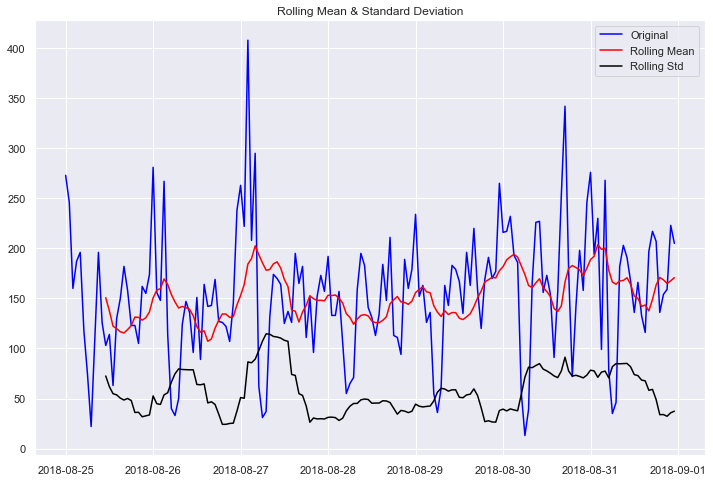

Results of Dickey-Fuller Test:
Test Statistic                -7.586326e+00
p-value                        2.600898e-11
#Lags Used                     2.000000e+00
Number of Observations Used    1.650000e+02
Critical Value (1%)           -3.470616e+00
Critical Value (5%)           -2.879221e+00
Critical Value (10%)          -2.576197e+00
dtype: float64


In [26]:
test_stationarity(df_one_week['num_orders'])

Параметры order и seasonal_order подбирала глядя на ACF и PACF диаграммы

<b>seasonal_order(P,Q,s)</b>: s - период в 24 часа, так пик в 24 положительный на ACF и PACF, то P=1, Q=0. D=1

<b>order(p,d,q)</b>: p=1, так как в <u>PACF</u> одно значение подряд не входит в доверительный интервал, ноль не берем в расчет, так как там всегда есть корреляция. d=0, так как не было преобразований ряда (вот здесь совсем не понятно почему логарфмируя ряд, p-value становится больше, то есть ряд становится не стационарным). q=1, так как в <u>ACF</u> одно значение подряд не входит в доверительный интервал

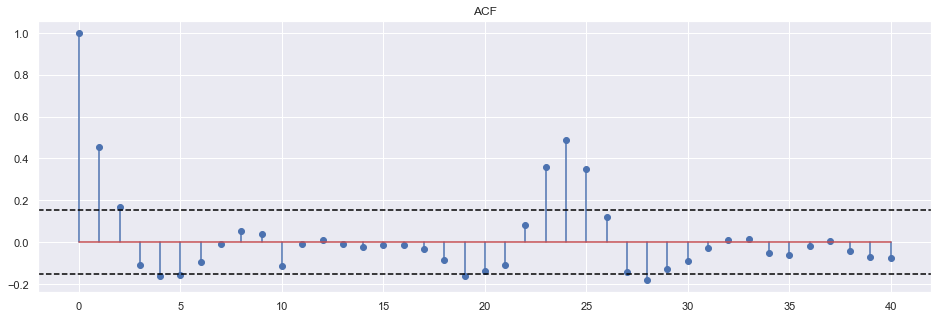

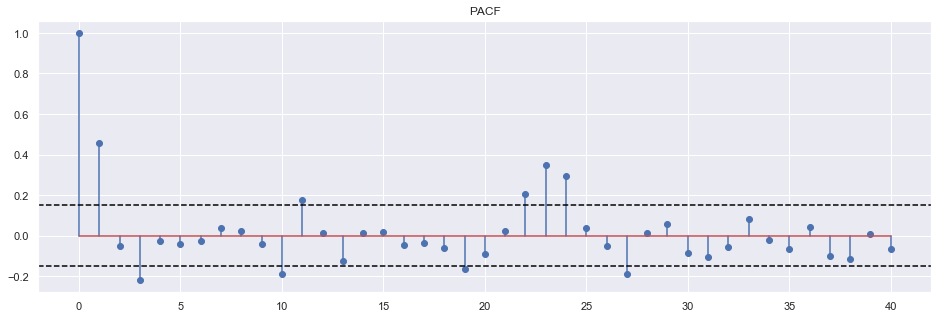

In [27]:
lag_acf = acf(df_one_week['num_orders'], nlags=40)
lag_pacf = pacf(df_one_week['num_orders'], nlags=40)

# plot ACF
#plt.subplot(122)
plt.stem(lag_acf)
plt.axhline(y=-1.96/np.sqrt(len(df_one_week)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_one_week)), linestyle='--', color='black')
plt.title('ACF')
plt.show()

# plot PACF
#plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=-1.96/np.sqrt(len(df_one_week)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(df_one_week)), linestyle='--', color='black')
plt.title('PACF')
plt.show()

In [28]:
mod = SARIMAX(df_one_week['num_orders'], trend='ct', order=(1,0,1), seasonal_order=(1,1,0,24))
results = mod.fit()
results.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          num_orders   No. Observations:                  168
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 24)   Log Likelihood                -765.823
Date:                             Tue, 24 Nov 2020   AIC                           1543.647
Time:                                     16:15:46   BIC                           1561.466
Sample:                                 08-25-2018   HQIC                          1550.887
                                      - 08-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3201      6.063      0.218      0.828     -10.563      13.203
drift          0.0120      0.057      0.212      0.832      -0.099       0.123
ar.L1          0.6680      0.264      2.527      0.012       0.150       1.186
ma.L1         -0.4969      0.312     -1.594      0.111      -1.108       0.114
ar.S.L24      -0.5487      0.046    -11.834      0.000      -0.640      -0.458
sigma2      2294.6031    182.203     12.594      0.000    1937.492    2651.715
===================================================================================
Ljung-Box (Q):                       31.26   Jarque-Bera (JB):               134.57
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.96
Prob(H) (two-sided):                  0.36   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

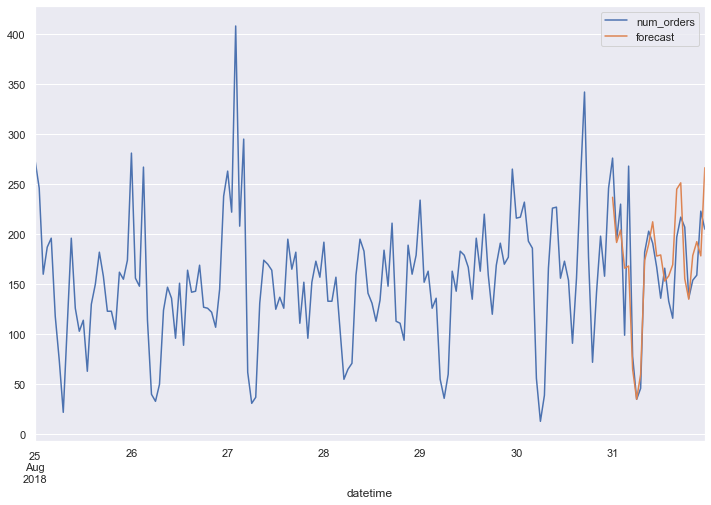

In [29]:
df_one_week['forecast'] = results.predict(start='2018-08-31', end='2018-08-31', dynamic= True)  
df_one_week[['num_orders', 'forecast']].plot(figsize=(12, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

39.26888475180272


,pred_previous,constant,LinearRegression,RandomForestRegressor,LGBM,sarima
RMSE_train,NaN,NaN,55.413404,22.260495,33.726775,NaN
RMSE_test,48.4392,46.2286,36.404503,34.078873,30.777833,39.2689


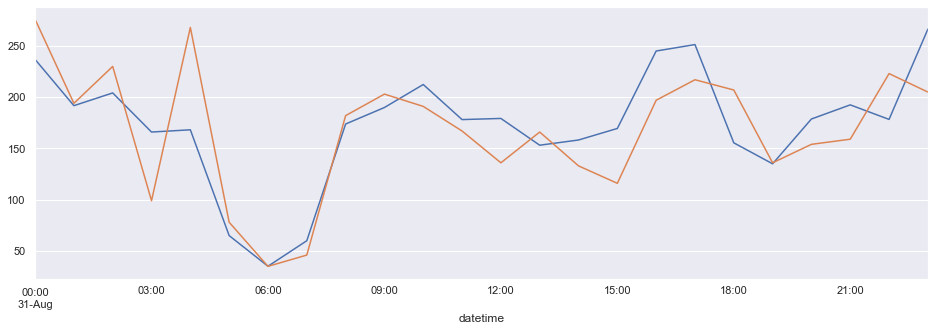

In [30]:
predict_sarima = df_one_week['forecast'].dropna()
test_sarima = df_one_week['num_orders']['2018-08-31':'2018-08-31']

predict_sarima.plot()
test_sarima.plot()

print(mean_squared_error(test_sarima, predict_sarima)**0.5)

results_dict['sarima'] = ['NaN']
results_dict['sarima'].append(mean_squared_error(test_sarima, predict_sarima)**0.5)
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

<a id='4'></a>
# Выводы
[К началу](#0)

In [31]:
pd.DataFrame(results_dict, index=['RMSE_train', 'RMSE_test'])

,pred_previous,constant,LinearRegression,RandomForestRegressor,LGBM,sarima
RMSE_train,NaN,NaN,55.413404,22.260495,33.726775,NaN
RMSE_test,48.4392,46.2286,36.404503,34.078873,30.777833,39.2689


Из таблицы выше видно, что все модели показывают результат лучше чем прогнозирование предыдущим значением или константой, но лучший результат с RMSE=25 показала модель LGBM. Посмотрим на график предсказаний для этой модели

RMSE тестовой выборки:  30.777832556788773


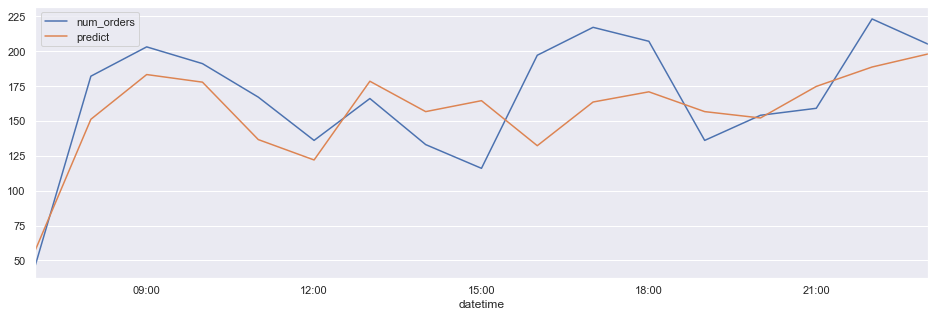

In [32]:
predict_results(LGBM_predict_test)

[К началу](#0)